### Implementation of textural variation in laminated sands using digital image analysis of thin sections (van den Berg, Bense and Schlager, 2003)

Trying to implement Berg et al, 2003 pipeline for textural variation analysis in sedimentary thin sections, albeit with no good thin section to use on (used sandLaminated.jpg that I found on the internet).



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2
import helper as hl
# Helper is a personal module where functions used in exploration notebook are stored for further use

In [31]:
FNAME = "sandLaminated.jpg"

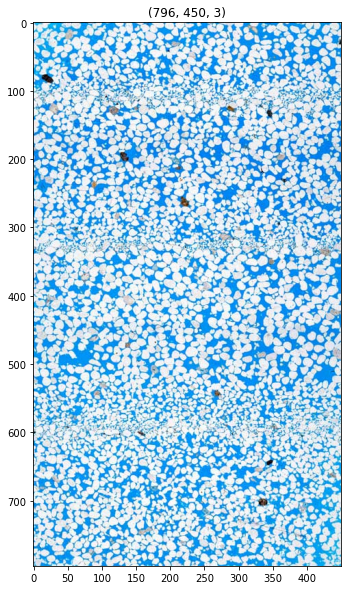

In [32]:
img = hl.load_img(FNAME)
hl.plot_rgb(img) 

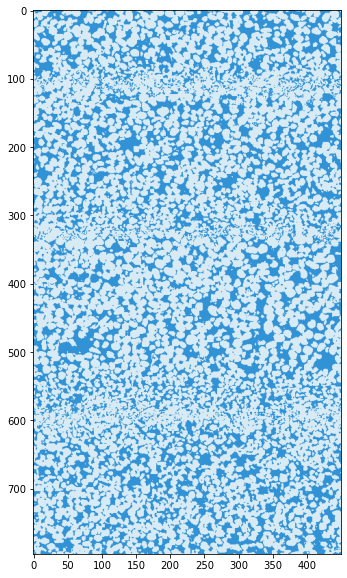

In [33]:
quantIMG = hl.quantize_image(img[:,:,::-1], n_clusters=2)
plt.imshow(quantIMG)

In [34]:
import sys
import cv2
import numpy
from scipy.ndimage import label
from skimage.filters import threshold_otsu

def segment_grains(img, iter):
    # taken from https://stackoverflow.com/questions/25789278/coffee-beans-separation-algorithm (thanks to karlphillip)
    def segment_on_dt(a, img, iter):
        border = cv2.dilate(img, None, iterations=iter)
        border = border - cv2.erode(border, None)
        #cv2.imwrite("border.png", border)

        dt = cv2.distanceTransform(img, 2, 5)    
        dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(numpy.uint8)
        _, dt = cv2.threshold(dt, threshold_otsu(img), 255, cv2.THRESH_BINARY)
        #cv2.imwrite("dt_thres.png", dt)
        lbl, ncc = label(dt)
        lbl = lbl * (255/ncc)      
        # Completing the markers now. 
        lbl[border == 255] = 255

        lbl = lbl.astype(numpy.int32)
        #cv2.imwrite("label.png", lbl)    
        cv2.watershed(a, lbl)

        lbl[lbl == -1] = 0
        lbl = lbl.astype(numpy.uint8)
        return 255 - lbl

    # Pre-processing.
    img_gray = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)    
    _, img_bin = cv2.threshold(img_gray.astype('uint8'), threshold_otsu(img), 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #cv2.imwrite("img_bin.png", img_bin)

    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, numpy.ones((3, 3), dtype=int))
    #cv2.imwrite("img_bin_morphoEx.png", img_bin)

    result = segment_on_dt(img, img_bin, iter)
    #cv2.imwrite("result.png", result)

    result[result != 255] = 0
    result = cv2.dilate(result, None)
    img[result == 255] = (0, 0, 255)
    return result

## lacks detection of fine grains in bands but further parameter tuning in progress

<ipython-input-34-db853c04a902>:33: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (796, 450, 3) looks like an RGB image
  _, img_bin = cv2.threshold(img_gray.astype('uint8'), threshold_otsu(img), 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)


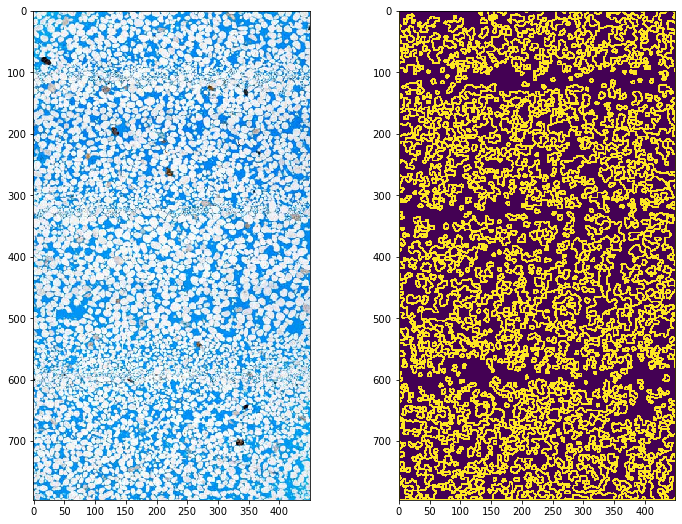

In [35]:
img = hl.load_img(FNAME)
result = segment_grains(img[:,:,::-1], iter=3)
hl.plot_images(hl.load_img(FNAME)[:,:,::-1], result)


In [7]:
def calculate_percentages(img):
    """calculate unique RGB colors in image img and return percentage values for each of these colors."""
    unique_colors = np.unique(img.reshape(-1, img.shape[2]), axis=0)
    pct = []
    for n in range(len(unique_colors)):
        pct.append(np.sum(img == unique_colors[n]) / img.size) 

    return unique_colors, pct

In [37]:
colors, pct = calculate_percentages(quantIMG)

In [38]:
colors = colors*255
colors

array([[ 49.76352482, 147.81595092, 214.36865588],
       [216.45681322, 234.95572186, 243.90427191]])

In [39]:
# rgb(49, 147, 214) is blue (porosity)
# rgb(216, 234, 244) is gray (grains)



In [51]:
pct

[0.3618397543271915, 0.6381602456728085]

## Do segmented count of total image

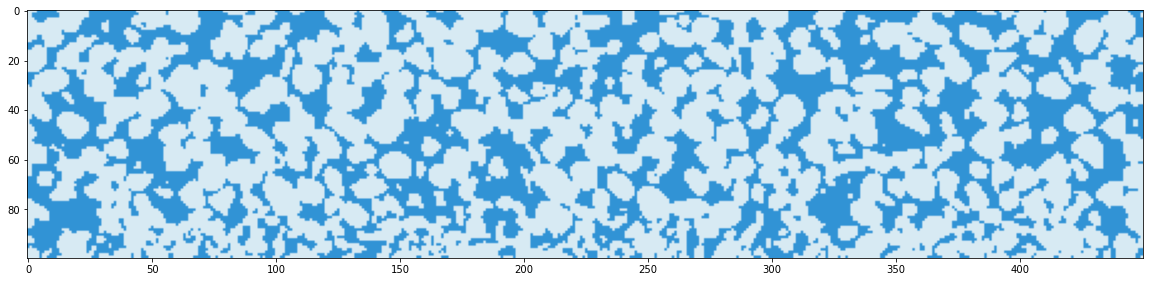

In [66]:
# plot slice of image

plt.imshow(quantIMG[:100, :, :])

In [62]:
def calculate_divisors(integer):
    """return all divisors of given integer"""
    divisors = []
    for i in range(1, integer):
        if integer % i == 0:
            divisors.append(i)
    return divisors

In [63]:
calculate_divisors(796)

[1, 2, 4, 199, 398]

In [65]:
height = quantIMG.shape[0]

# total_pcts = (pct porosity, pct grain)
total_pcts = []
for i in range(0, height, 1):
    _, pct = calculate_percentages(quantIMG[i:i+1, :])
    total_pcts.append(pct)


In [66]:
def unnest_list(ls):
    """return unnested list ls"""
    return [item for sublist in ls for item in sublist]

unnested_pcts = unnest_list(total_pcts)

In [67]:
porosity = []
for i in total_pcts:
    porosity.append(i[0])

grains = []
for i in total_pcts:
    grains.append(i[1])

In [68]:
def plot_img_and_hist(img, ls, ls2):
    """plot image img and besides plot vertical line with values in list ls"""
    plt.figure()
    plt.subplot(131).set_title("Quantized Image")
    plt.imshow(img)
    plt.subplot(132).set_title("Grain Percentage each vertical pixel")
    plt.plot(ls,range(len(ls)))
    plt.subplot(133).set_title("Porosity Percentage each vertical pixel")

    plt.plot(ls2,range(len(ls2)))
    plt.show()

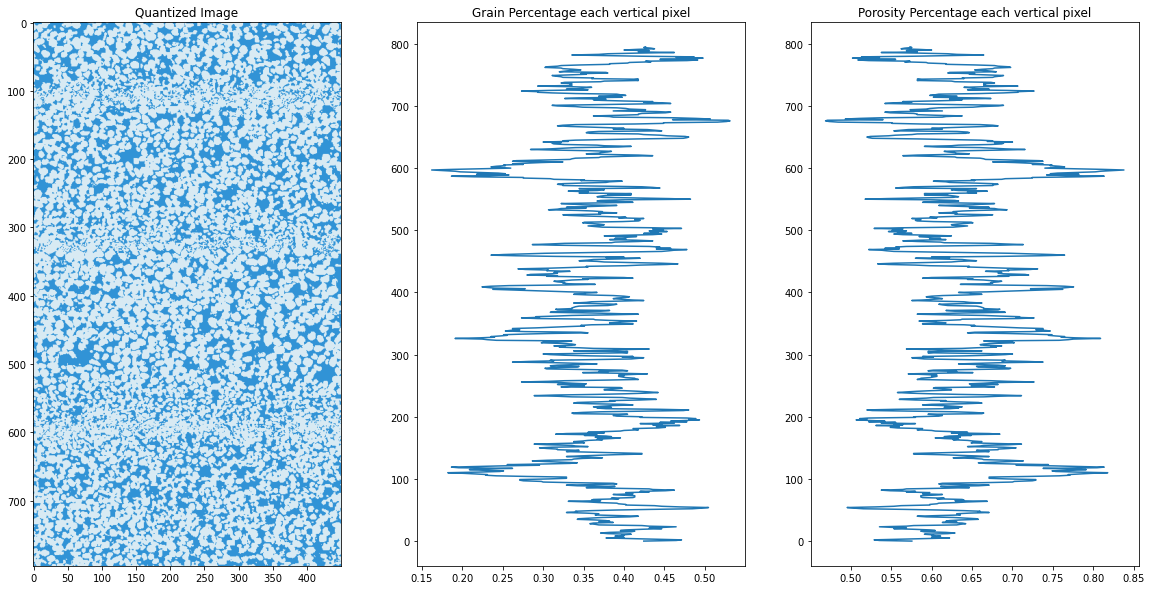

In [69]:
plot_img_and_hist(quantIMG, porosity, grains)

### Testing with laminated BW high-res photo

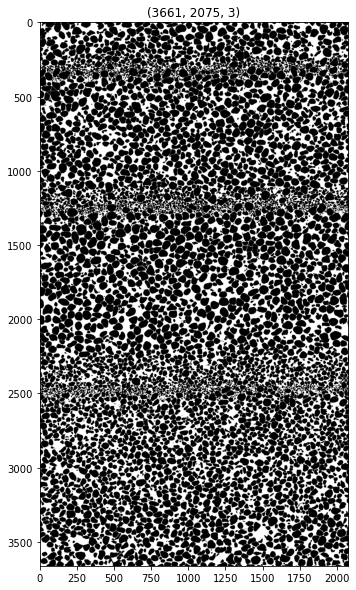

In [70]:
FNAME = "bw_laminated.jpg"
img = hl.load_img(FNAME)
hl.plot_rgb(img) 

In [73]:
img.shape

(3661, 2075)

In [89]:
def calculate_bw_percentage(img):
    """Calculate percentage of black and white colors in given image"""

    _, img_bin = cv2.threshold(img.astype('uint8'), threshold_otsu(img), 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    return np.sum(img_bin == 0) / img_bin.size, np.sum(img_bin == 255) / img_bin.size

In [98]:
height = img.shape[0]

# total_pcts = (pct porosity, pct grain)
total_pcts = []
for i in range(0, height, 10):
    pct = calculate_bw_percentage(img[i:i+10, :])
    total_pcts.append(pct)

In [99]:
porosity = []
for i in total_pcts:
    porosity.append(i[0])

grains = []
for i in total_pcts:
    grains.append(i[1])

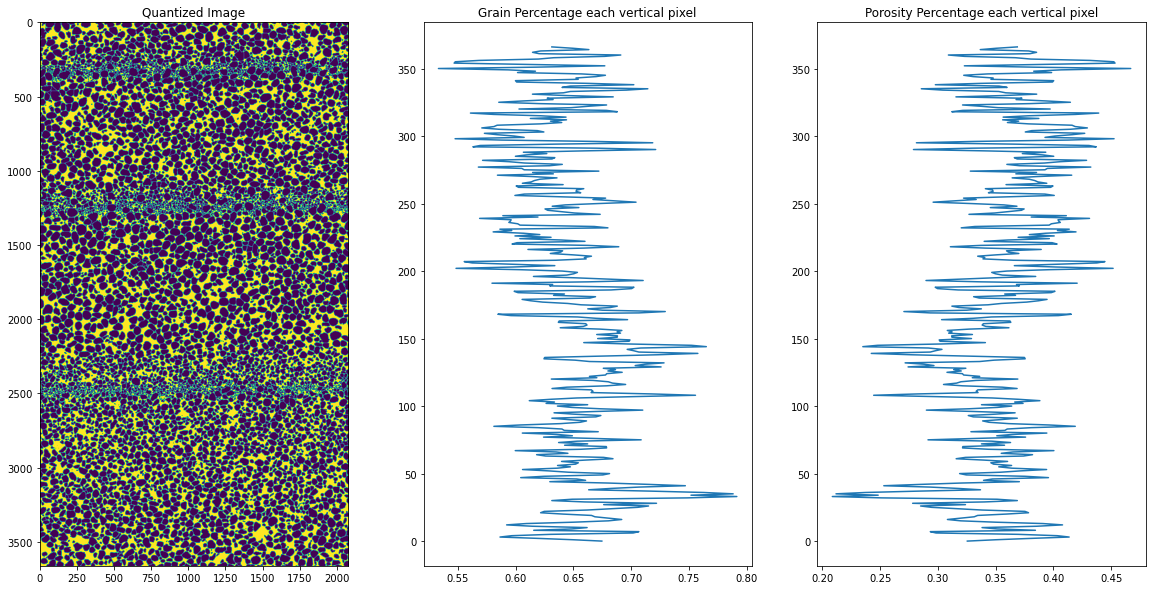

In [100]:
plot_img_and_hist(img, porosity, grains)


## Test if with color segmentation and opaque thin sections it could be possible to make a first approximation to a mineral abundance line in a metalic ore thin section

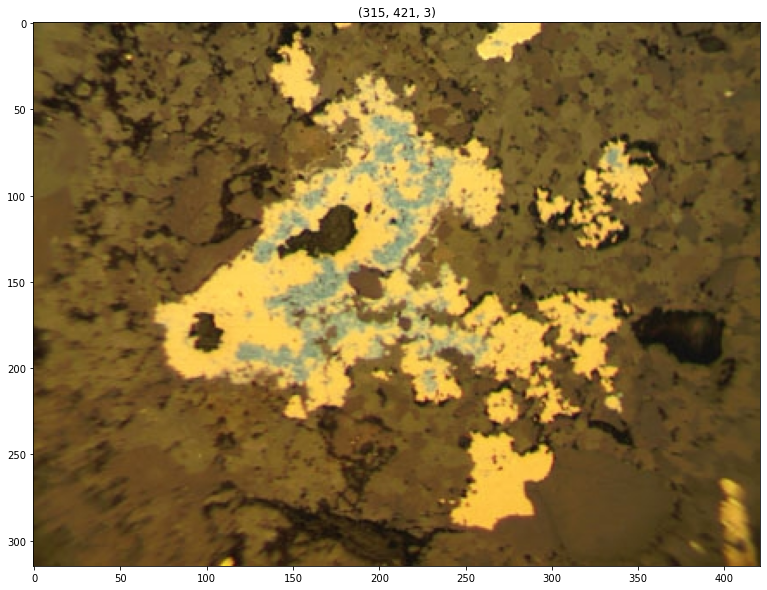

In [3]:
FNAME = "test_opaque.jpg"
img = hl.load_img(FNAME)
hl.plot_rgb(img) 

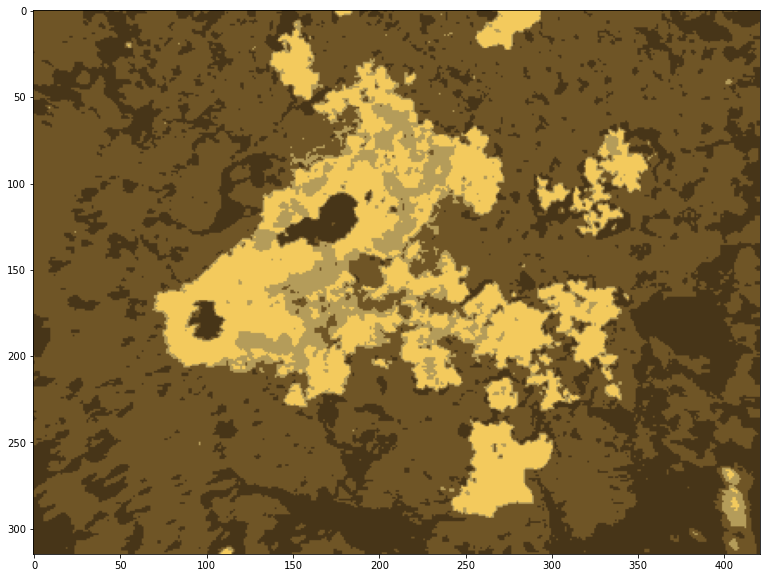

In [5]:
quantIMG = hl.quantize_image(img[:,:,::-1], n_clusters=4) # assume four different minerals
plt.imshow(quantIMG)

In [8]:
colors, pct = calculate_percentages(quantIMG)

In [13]:
# four different colors, assumed to be four different minerals
colors*255

array([[ 71.42793988,  53.5994695 ,  24.62157383],
       [111.57390382,  85.10749646,  38.67574257],
       [180.4933687 , 156.45888594,  90.44297082],
       [243.62951807, 202.60542169,  93.54216867]])